<a href="https://colab.research.google.com/github/tutur90/Weather-Forecast/blob/main/Data_Imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Data Imputation<h1>

On this notebook, we will try to determine the better model for imputation on our dataset of wather

# Imports

In [ ]:
!pip install pypots            # the first time installation
!pip install pypots --upgrade  # update pypots to the latest version

In [ ]:
import pandas as pd
import missingno as msno
import numpy as np
from sklearn.preprocessing import StandardScaler


# Data

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/marsgr6/r-scripts/master/data/WC_INA_Final.csv")

# df.set_index('Oni_date', inplace=True, drop=True)

df.drop(columns=['Oni_date', 'ONI', 'ElNino Index 1,2_temp', 'ElNino Index 1,2_annomaly'], inplace=True)

var = ''

df_in = df.loc[:, df.columns.str.startswith('IN_'+var)]
df_wc = df.loc[:, df.columns.str.startswith('WC_'+var)]

df.head()

,WC_Tx_Muis,WC_Tn_Muis,WC_Ra_Muis,WC_Tx_Quin,WC_Tn_Quin,WC_Ra_Quin,WC_Tx_Pvie,WC_Tn_Pvie,WC_Ra_Pvie,WC_Tx_Chon,...,IN_Tx_Sang,IN_Ra_Sang,IN_Ta_Tena,IN_Tn_Tena,IN_Tx_Tena,IN_Ra_Tena,IN_Ta_Yanz,IN_Tn_Yanz,IN_Tx_Yanz,IN_Ra_Yanz
0,29.0,22.0,234.3,29.0,21.0,315.8,31.0,21.0,67.0,30.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30.0,22.0,193.1,30.0,21.0,249.9,30.0,22.0,72.2,30.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30.0,22.0,231.0,30.0,21.0,402.8,31.0,22.0,112.7,31.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30.0,22.0,141.8,30.0,21.0,236.2,31.0,21.0,46.8,31.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29.0,21.0,79.8,30.0,21.0,103.4,30.0,20.0,14.8,29.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

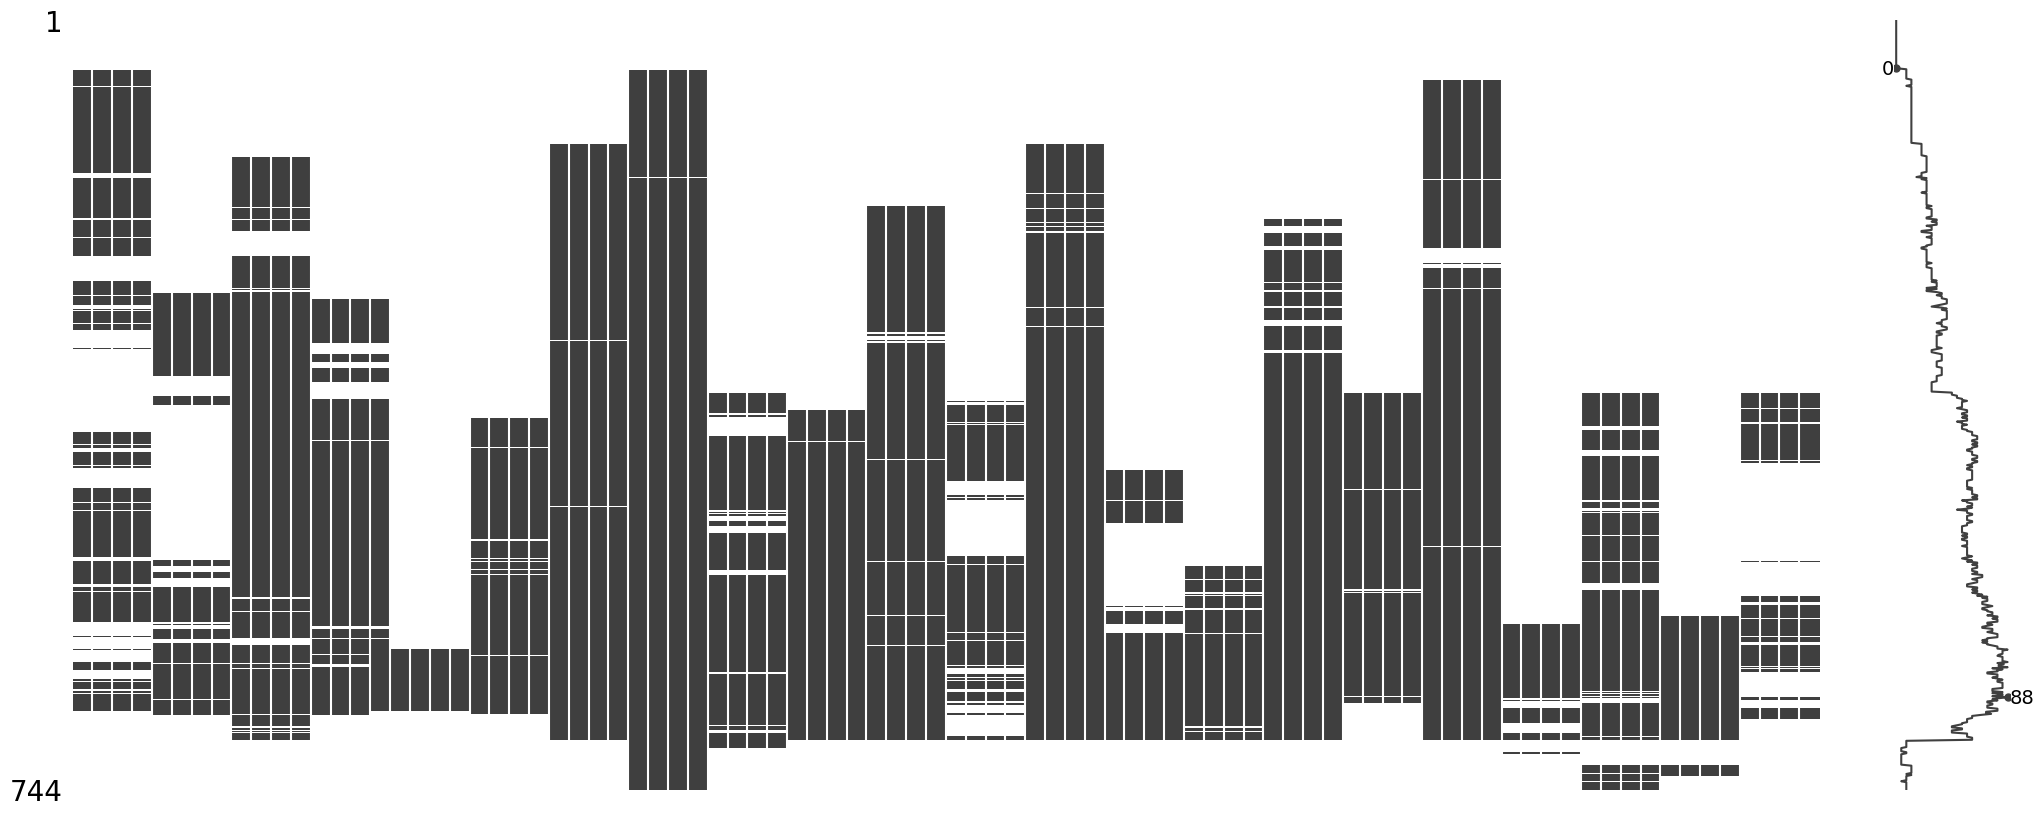

In [ ]:
msno.matrix(df_in)

# Create a train set and validation set

In [ ]:
city_list = []

for i in df.columns:
  city = i.split('_')[-1]
  if city not in city_list:
    city_list.append(city)

print(city_list)


['Muis', 'Quin', 'Pvie', 'Chon', 'Calc', 'Guaq', 'Mila', 'Scru', 'Scri', 'Guag', 'Taba', 'Quit', 'Papa', 'Izob', 'Sier', 'Lumb', 'Yasu', 'Glqz', 'Tena', 'Maca', 'Sang', 'Puyo', 'Yanz']


In [ ]:
np.random.seed(9)  # Set seed for reproducibility

def get_consecutive_non_nan(df, start_index=None, percent = 0.2, max_attempts=1000, ):

    n = int(len(df.dropna()) * percent) -1


    if start_index is not None:
      return df.loc[start_index:start_index+n]

    else:
      for _ in range(max_attempts):
          # Try random starting index
          start_index = np.random.randint(0, len(df) - n)
          # Check if 10 consecutive values are non-NaN
          if not df.loc[start_index:start_index+n].isna().any().any():
              print(start_index)
              return df.loc[start_index:start_index+n]
    raise ValueError("Couldn't find 10 consecutive non-NaN values after %d attempts" % max_attempts)

We can use or not the world clim data for the prediction

On validation set, we can simulate hold by ramdom unifom ablation of values or by random block ablation, witch represente better the hole of the original data set

<Axes: >

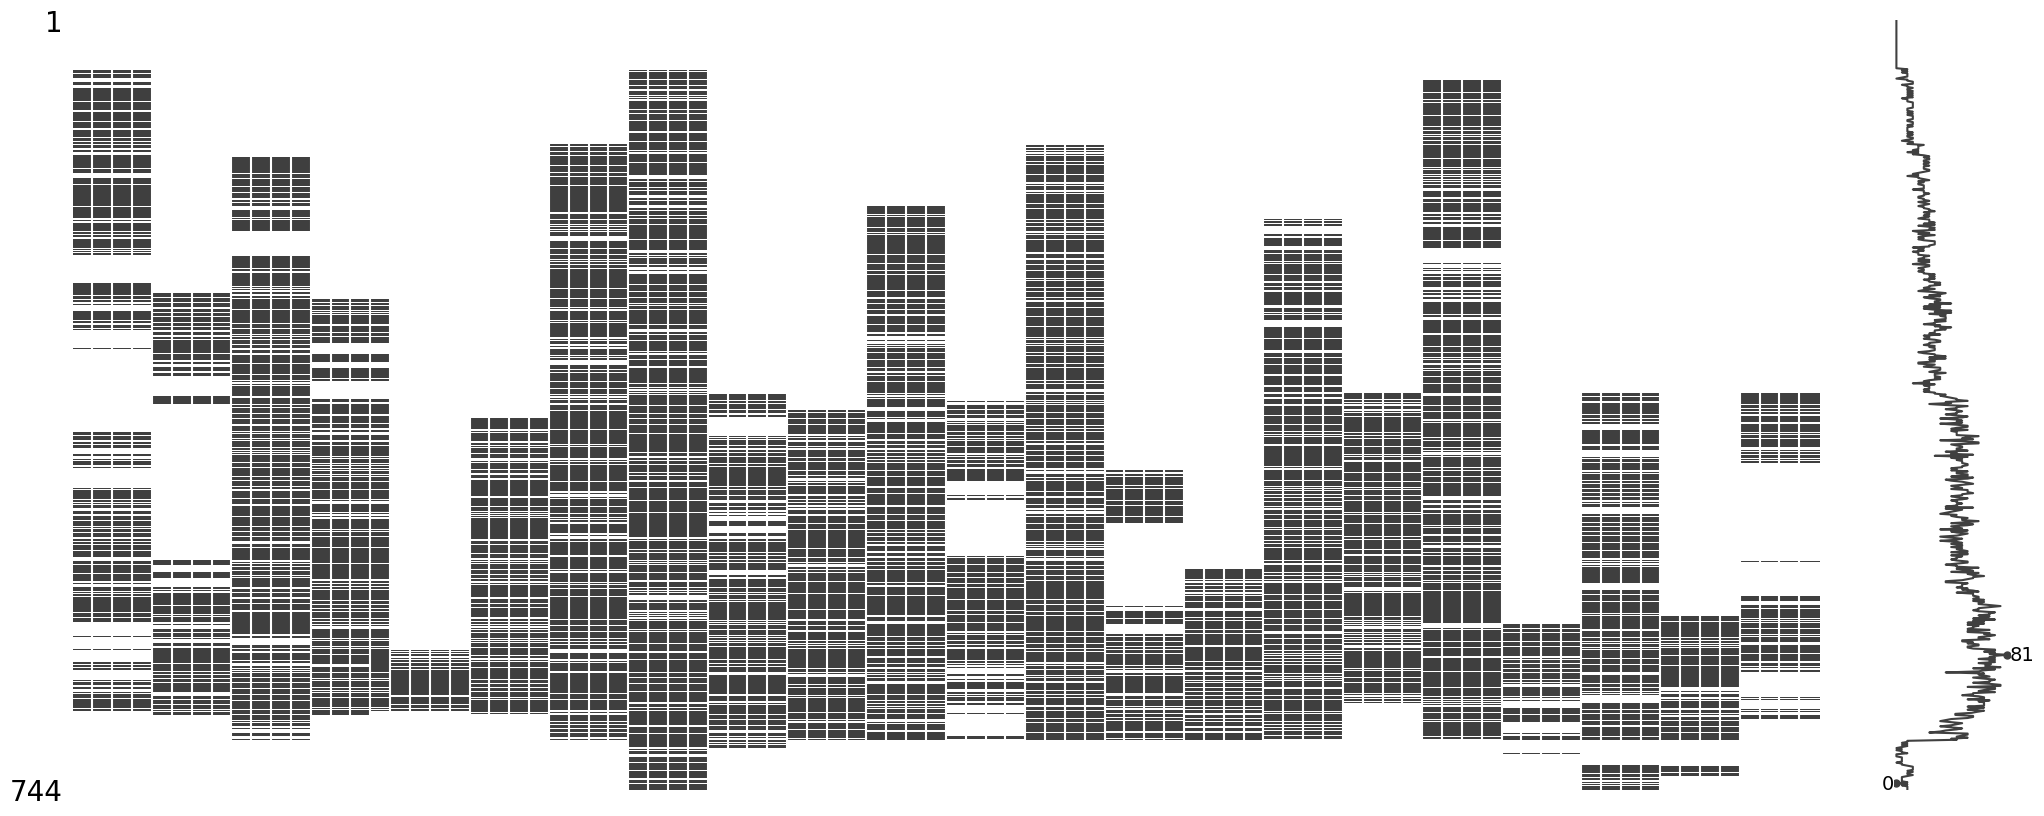

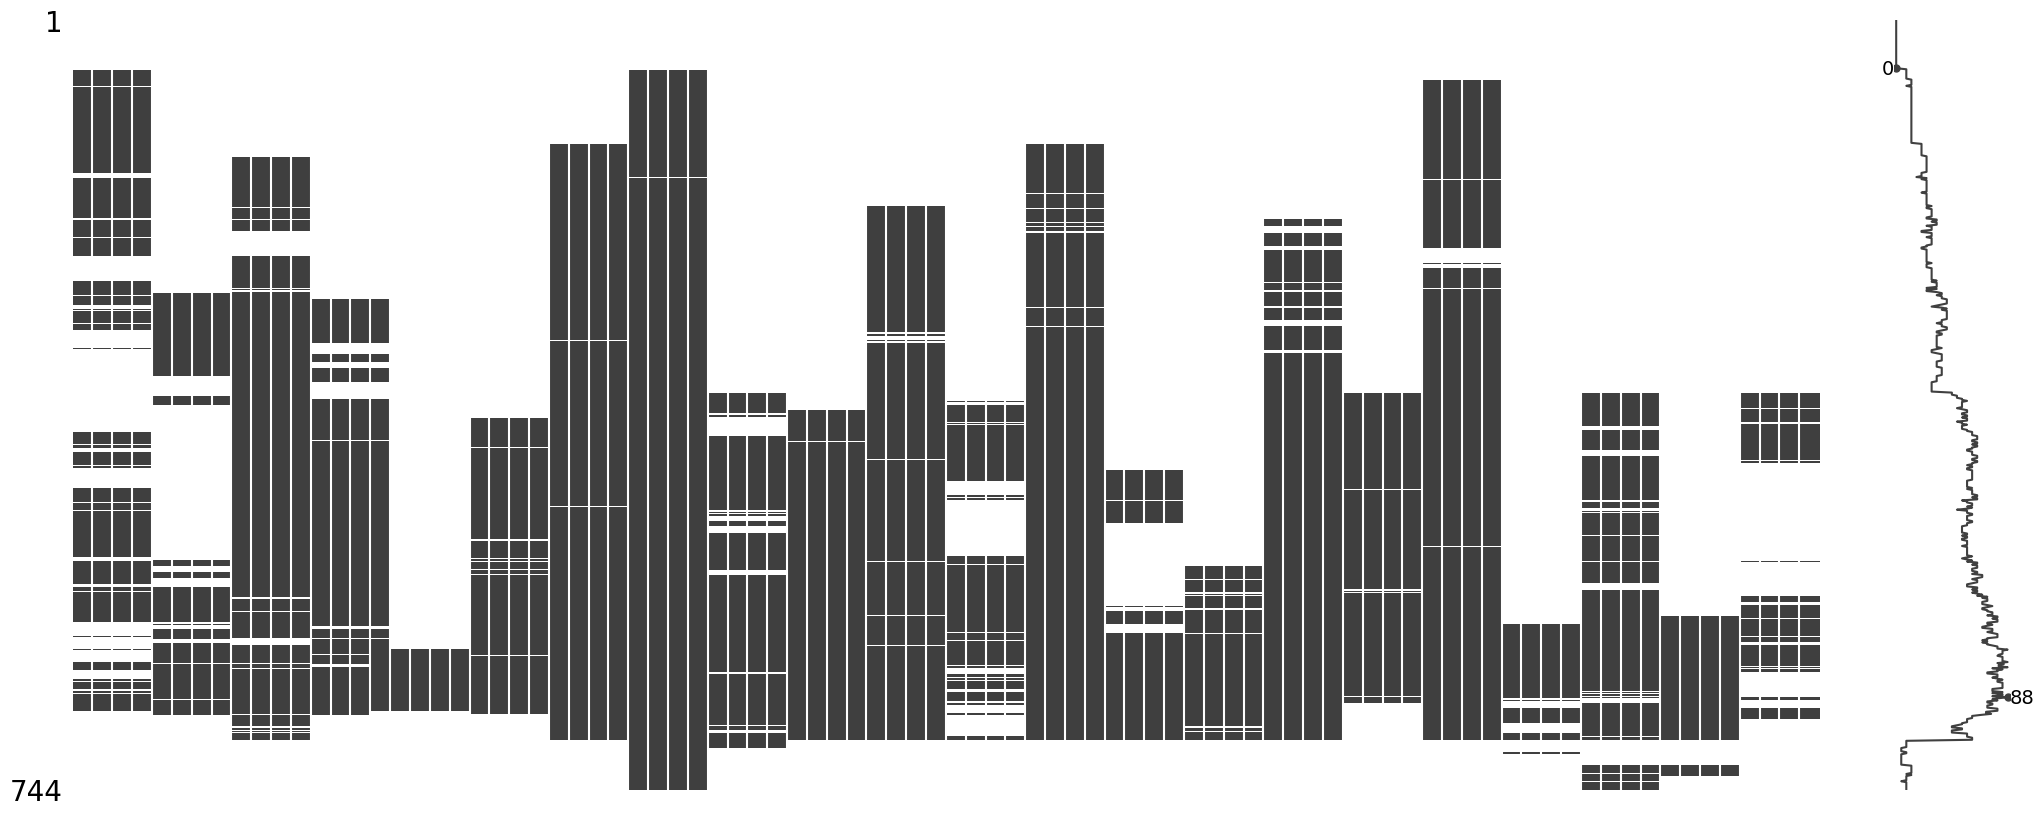

In [ ]:
cat_wc = False

block_hole = False

starts_index = [67,270,388,474,656,331,314,209,551,432,515,189,394,512,597,616,359,575,640,599,560,365,390]

train_df = df_in.copy()

for i, c in enumerate(city_list):


  col = train_df.loc[:, train_df.columns.str.endswith(c)]

  if block_hole:
    idx = get_consecutive_non_nan(col).index
  else:
    idx = col.dropna().sample(len(col.dropna())*2//10).index

  train_df.loc[idx, train_df.columns.str.endswith(c)] = float('nan')


train_df = train_df.sort_index()


if cat_wc:

  train_df = train_df.join( df_wc)

  ori_df = df_in.join( df_wc)

else:
  ori_df=df_in

scaler = StandardScaler()

train_df = pd.DataFrame(scaler.fit_transform(train_df.to_numpy()), columns=train_df.columns)
ori_df = pd.DataFrame(scaler.transform(ori_df.to_numpy()), columns=ori_df.columns)


msno.matrix(train_df)

msno.matrix(ori_df)


# Utilities

In [ ]:
import plotly.express as px

def plot(df1, df2, col = 'IN_Ta_Muis', n1 = '1', n2 = '2'):
  ndf = pd.DataFrame()

  ndf[n1] = df1[col]
  ndf[n2] = df2[col]

  fig = px.line(ndf, x=ndf.index, y=ndf.columns, title=col, )
  fig.show(renderer="colab")



In [ ]:
from pypots.utils.metrics import calc_mae, calc_mse

def metrics(imputation, X, X_ori):
  indicating_mask = np.isnan(X) ^ np.isnan(X_ori)
  mae = calc_mae(imputation, np.nan_to_num(X_ori), indicating_mask)  # calculate mean absolute error on the ground truth (artificially-missing values)
  mse = calc_mse(imputation, np.nan_to_num(X_ori), indicating_mask)

  print(' MAE: ',mae, 'MSE: ', mse)

# Test of differents models

## SAITS



In [ ]:

# pip install pypots>=0.4
import numpy as np
from sklearn.preprocessing import StandardScaler
from pygrinder import mcar
from pypots.data import load_specific_dataset
from pypots.imputation import SAITS


X = train_df.to_numpy()

n_features = X.shape[-1]
n_steps =  31 * 3 * 2 * 2 * 2
X = X.reshape(-1, n_steps, n_features)
X_ori = ori_df.to_numpy().reshape(-1, n_steps, n_features)
dataset = {"X": X}  # X for model input
print(X.shape) # (1, 744, 154), 1 sample and each sample has 744 time steps, 154 features

# Model training. This is PyPOTS showtime.
saits = SAITS(n_steps=n_steps, n_features=n_features, n_layers=2, d_model=256*4, d_ffn=128*4, n_heads=4*2, d_k=64*2, d_v=64*2, dropout=0., epochs=50)
# saits = SAITS(n_steps=n_steps, n_features=n_features, n_layers=2, d_model=256*2, d_ffn=128*4, n_heads=4*2, d_k=64, d_v=64, dropout=0., epochs=50)
# Here I use the whole dataset as the training set because ground truth is not visible to the model, you can also split it into train/val/test sets
saits.fit(dataset)
imputation = saits.predict(dataset)  # impute the originally-missing values and artificially-missing values
indicating_mask = np.isnan(X) ^ np.isnan(X_ori)  # indicating mask for imputation error calculation

metrics(imputation['imputation'], X, X_ori)  # calculate mean absolute error on the ground truth (artificially-missing values)

imp_df = pd.DataFrame(imputation['imputation'].reshape(-1, n_features), columns=train_df.columns)


plot(imp_df, train_df, n1='predicted', n2 = 'train set')
plot(imp_df, ori_df, n1='predicted', n2 = 'original data')


2024-05-08 22:43:06 [INFO]: No given device, using default device: cpu
2024-05-08 22:43:06 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2024-05-08 22:43:06 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 22,104,896


(1, 744, 154)


2024-05-08 22:43:08 [INFO]: Epoch 001 - training loss: 1.6609
2024-05-08 22:43:11 [INFO]: Epoch 002 - training loss: 2.0262
2024-05-08 22:43:13 [INFO]: Epoch 003 - training loss: 1.6509
2024-05-08 22:43:16 [INFO]: Epoch 004 - training loss: 1.4331
2024-05-08 22:43:19 [INFO]: Epoch 005 - training loss: 1.5525
2024-05-08 22:43:21 [INFO]: Epoch 006 - training loss: 1.3727
2024-05-08 22:43:23 [INFO]: Epoch 007 - training loss: 1.2140
2024-05-08 22:43:25 [INFO]: Epoch 008 - training loss: 1.1993
2024-05-08 22:43:28 [INFO]: Epoch 009 - training loss: 1.1641
2024-05-08 22:43:31 [INFO]: Epoch 010 - training loss: 1.1186
2024-05-08 22:43:34 [INFO]: Epoch 011 - training loss: 1.0838
2024-05-08 22:43:36 [INFO]: Epoch 012 - training loss: 1.0631
2024-05-08 22:43:38 [INFO]: Epoch 013 - training loss: 1.0513
2024-05-08 22:43:41 [INFO]: Epoch 014 - training loss: 0.9980
2024-05-08 22:43:45 [INFO]: Epoch 015 - training loss: 0.9803
2024-05-08 22:43:47 [INFO]: Epoch 016 - training loss: 0.9623
2024-05-

In [ ]:
vars = ['R', 'T']

imp_df = []
for v in vars:

  X = train_df.loc[:, train_df.columns.str.startswith('IN_'+v)+train_df.columns.str.startswith('WC_'+v)].to_numpy()

  n_features = X.shape[-1]
  n_steps =  31 * 3 * 2 * 2 * 2
  X = X.reshape(-1, n_steps, n_features)
  X_ori = ori_df.loc[:, ori_df.columns.str.startswith('IN_'+v)+ori_df.columns.str.startswith('WC_'+v)].to_numpy().reshape(-1, n_steps, n_features)
  dataset = {"X": X}  # X for model input
  print(X.shape) # (1, 744, 154), 1 sample and each sample has 744 time steps, 154 features

  # Model training. This is PyPOTS showtime.
  saits = SAITS(n_steps=n_steps, n_features=n_features, n_layers=2, d_model=256*2, d_ffn=128*4, n_heads=4, d_k=64*2, d_v=64*2, dropout=0., epochs=50)
  # saits = SAITS(n_steps=n_steps, n_features=n_features, n_layers=2, d_model=256*4, d_ffn=128*4, n_heads=4*2, d_k=64*2, d_v=64*2, dropout=0., epochs=50)
  # Here I use the whole dataset as the training set because ground truth is not visible to the model, you can also split it into train/val/test sets
  saits.fit(dataset)
  imputation = saits.predict(dataset)  # impute the originally-missing values and artificially-missing values
  indicating_mask = np.isnan(X) ^ np.isnan(X_ori)  # indicating mask for imputation error calculation

  mae = calc_mae(imputation['imputation'], np.nan_to_num(X_ori), indicating_mask)  # calculate mean absolute error on the ground truth (artificially-missing values)
  mse = calc_mse(imputation['imputation'], np.nan_to_num(X_ori), indicating_mask)

  print(v,' MAE: ',mae, 'MSE: ', mse)


  imp_df.append(pd.DataFrame(imputation['imputation'].reshape(-1, n_features), columns=train_df.loc[:, train_df.columns.str.startswith('IN_'+v)+train_df.columns.str.startswith('WC_'+v)].columns))


imp_df = pd.concat(imp_df, axis=1).reindex(columns=ori_df.columns)

indicating_mask = np.isnan(train_df.to_numpy()) ^ np.isnan(ori_df.to_numpy())



mae = calc_mae(imp_df.to_numpy(), np.nan_to_num(ori_df.to_numpy()), indicating_mask)
mse = calc_mse(imp_df.to_numpy(), np.nan_to_num(ori_df.to_numpy()), indicating_mask)

print('TOTAL MAE: ',mae, 'MSE: ', mse)

plot(imp_df, train_df, n1='predicted', n2 = 'train set')
plot(imp_df, ori_df, n1='predicted', n2 = 'original data')

## KNN

In [ ]:
from sklearn.impute import KNNImputer

X = X.reshape(-1, n_features)
X_ori = scaler.transform(ori_df.to_numpy()).reshape(-1 , n_features)

imputer = KNNImputer(n_neighbors=5)

imputation = imputer.fit_transform(X)

metrics(imputation, X, X_ori)  # calculate mean absolute error on the ground truth (artificially-missing values)

imp_df = pd.DataFrame(scaler.inverse_transform(imputation.reshape(-1, n_features)), columns=train_df.columns)



plot(imp_df, train_df, n1='predicted', n2 = 'train set')
plot(imp_df, ori_df, n1='predicted', n2 = 'original data')


## iTransformer

In [ ]:

# pip install pypots>=0.4
import numpy as np
from sklearn.preprocessing import StandardScaler
from pygrinder import mcar
from pypots.data import load_specific_dataset
from pypots.imputation import iTransformer
from pypots.utils.metrics import calc_mae

scaler = StandardScaler()

X = scaler.fit_transform(train_df.to_numpy())

n_features = X.shape[-1]
n_steps = 2 * 2 * 2 * 3 * 31
X = X.reshape(-1, n_steps, n_features)
X_ori = scaler.transform(ori_df.to_numpy()).reshape(-1, n_steps, n_features)
dataset = {"X": X}  # X for model input
print(X.shape)  # (1, 744, 154), 1 sample and each sample has 744 time steps, 37 features

# Model training
saits = iTransformer(n_steps=n_steps, n_features=n_features, n_layers=4, d_model=256*4, d_ffn=128*4, n_heads=4*2, d_k=64*2, d_v=64*2, dropout=0.1, epochs=50)
# Here I use the whole dataset as the training set because ground truth is not visible to the model, you can also split it into train/val/test sets
saits.fit(dataset)
imputation = saits.predict(dataset)  # impute the originally-missing values and artificially-missing values

metrics(imputation['imputation'], X, X_ori)  # calculate mean absolute error on the ground truth (artificially-missing values)

imp_df = pd.DataFrame(scaler.inverse_transform(imputation['imputation'].reshape(-1, n_features)), columns=train_df.columns)

plot(imp_df, train_df, n1='predicted', n2 = 'train set')
plot(imp_df, ori_df, n1='predicted', n2 = 'original data')


## DLinear

In [ ]:
# pip install pypots>=0.4
import numpy as np
from sklearn.preprocessing import StandardScaler
from pygrinder import mcar
from pypots.data import load_specific_dataset
from pypots.imputation import DLinear
from pypots.utils.metrics import calc_mae

scaler = StandardScaler()

X = scaler.fit_transform(train_df.to_numpy())

n_features = X.shape[-1]
n_steps = 2 * 2 * 2 * 3 * 31
X = X.reshape(-1, n_steps, n_features)
X_ori = scaler.transform(ori_df.to_numpy()).reshape(-1, n_steps, n_features)
dataset = {"X": X}  # X for model input
print(X.shape)  # (11988, 48, 37), 11988 samples and each sample has 48 time steps, 37 features
# Model training. This is PyPOTS showtime.
saits = DLinear(n_steps=n_steps, n_features=n_features, d_model=256, moving_avg_window_size=32, epochs=50)
# Here I use the whole dataset as the training set because ground truth is not visible to the model, you can also split it into train/val/test sets
saits.fit(dataset)
imputation = saits.predict(dataset)  # impute the originally-missing values and artificially-missing values
indicating_mask = np.isnan(X) ^ np.isnan(X_ori)  # indicating mask for imputation error calculation

mae = calc_mae(imputation['imputation'], np.nan_to_num(X_ori), indicating_mask)  # calculate mean absolute error on the ground truth (artificially-missing values)

imp_df = pd.DataFrame(scaler.inverse_transform(imputation['imputation'].reshape(-1, n_features)), columns=train_df.columns, index=train_df.index)



plot(imp_df, train_df)
plot(imp_df, ori_df)

print(mae)

## LOCF

In [ ]:
# pip install pypots>=0.4
import numpy as np
from sklearn.preprocessing import StandardScaler
from pypots.data import load_specific_dataset
from pypots.imputation import LOCF
from pypots.utils.metrics import calc_mae


scaler = StandardScaler()

X = scaler.fit_transform(train_df.to_numpy())

n_features = X.shape[-1]
n_steps = 2 * 2 * 2 * 3 * 31
X = X.reshape(-1, n_steps, n_features)
X_ori = scaler.transform(ori_df.to_numpy()).reshape(-1, n_steps, n_features)
dataset = {"X": X}  # X for model input
print(X.shape)  # (11988, 48, 37), 11988 samples and each sample has 48 time steps, 37 features

# Model training. This is PyPOTS showtime.
saits = LOCF()
# Here I use the whole dataset as the training set because ground truth is not visible to the model, you can also split it into train/val/test sets

imputation = saits.predict(dataset)  # impute the originally-missing values and artificially-missing values
metrics(imputation['imputation'], X, X_ori)  # calculate mean absolute error on the ground truth (artificially-missing values)

# Results

Uniform holes eval

| Model | MAE | MSE |
| :- | -: | :-: |
| SAITS | 0.4160 | 0.3661
| iTransformer| 0.5050 |  0.5048
| KNN | 0.5423 | 0.5812
| LOCF | 0.7041 | 0.9204

Block holes eval

| Model | MAE | MSE |
| :- | -: | :-: |
| SAITS | 0.4782 | 0.4863
| iTransformer| 0.5159 |  0.5509
| KNN | 0.5399 |  0.5982
| LOCF | 1.0709 | 2.0678

SAITS Whithout WC  MAE:  0.5243 MSE:  0.5464

It's appear clearly that SAITS is the better model, so we will choose it


# New data

In [ ]:
scaler = StandardScaler()

X = scaler.fit_transform(ori_df.to_numpy())

n_features = X.shape[-1]
n_steps =  31 * 3 * 2 * 2 * 2
X = X.reshape(-1, n_steps, n_features)
X_ori = scaler.transform(ori_df.to_numpy()).reshape(-1, n_steps, n_features)
dataset = {"X": X}  # X for model input
print(X.shape)  # (11988, 48, 37), 11988 samples and each sample has 48 time steps, 37 features

# Model training. This is PyPOTS showtime.
saits = SAITS(n_steps=n_steps, n_features=n_features, n_layers=2, d_model=256*2, d_ffn=128*4, n_heads=4*2, d_k=64, d_v=64, dropout=0., epochs=50)
# Here I use the whole dataset as the training set because ground truth is not visible to the model, you can also split it into train/val/test sets
saits.fit(dataset)
imputation = saits.predict(dataset)  # impute the originally-missing values and artificially-missing values

imp_df = pd.DataFrame(scaler.inverse_transform(imputation['imputation'].reshape(-1, n_features)), columns=ori_df.columns, index=ori_df.index)

df = pd.read_csv("https://raw.githubusercontent.com/marsgr6/r-scripts/master/data/WC_INA_Final.csv")

# df.set_index('Oni_date', inplace=True, drop=True)

imp_df[['Oni_date', 'ONI', 'ElNino Index 1,2_temp', 'ElNino Index 1,2_annomaly']] = df[['Oni_date', 'ONI', 'ElNino Index 1,2_temp', 'ElNino Index 1,2_annomaly']]

imp_df.to_csv('data.csv')